### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import torch, torch.nn as nn
import torchsummary

from IPython.display import clear_output
from gensim.models import word2vec
from google.colab import drive
from torch.utils.data import Dataset

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

### Data preprocessing

In [ ]:
drive.mount('/content/drive')

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
# shuffle data a little bit
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [5]:
# preprocessing utils
to_lower = lambda x: x.lower()
split_sentence = lambda x: x.split()
remove_punct = lambda x: re.sub('[^a-z ]', '', x)

In [6]:
train_corpus = train_data['text'].apply(to_lower).apply(remove_punct)  # list of sentence
train_texts = train_corpus.apply(split_sentence).tolist()  # list of lists of strings

test_corpus = test_data['text'].apply(to_lower).apply(remove_punct)  # list of sentence
test_texts = test_corpus.apply(split_sentence).tolist()  # list of lists of strings

In [7]:
categories = {}
labels = {}
for n, cat in enumerate(np.unique(train_data['category'])):
    categories[cat] = n
    labels[n] = cat
len(categories)

77

In [8]:
categories_to_label = lambda x: categories[x]  # string to int
label_to_categories = lambda x: labels[x]      # int to string

In [9]:
y_train = train_data['category'].apply(categories_to_label).tolist()
y_test = test_data['category'].apply(categories_to_label).tolist()

### First approach (classic ml models)

In [10]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus.tolist())
X_test = vectorizer.transform(test_corpus.tolist())

In [11]:
def benchmark(clf):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = f1_score(y_test, pred, average='micro')
    print("accuracy:   %0.3f" % score)
    return score


results = []
for clf, name in (
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

# Train Liblinear model
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print(f"LinearSVC with {penalty.upper()} penalty")
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet")))

# Train Naive Bayes classifiers
print('=' * 80)
print("Multinomial Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))

print('=' * 80)
print("Bernoulli Naive Bayes")
results.append(benchmark(BernoulliNB(alpha=.01)))

Perceptron
accuracy:   0.844
Passive-Aggressive
accuracy:   0.875
kNN
accuracy:   0.811
Random forest
accuracy:   0.871
LinearSVC with L2 penalty
accuracy:   0.894
LinearSVC with L1 penalty
accuracy:   0.876
Elastic-Net penalty
accuracy:   0.876
Multinomial Naive Bayes
accuracy:   0.854
Bernoulli Naive Bayes
accuracy:   0.864


Метод опорных векторов лучше всех показал себя в этой задаче. Сохраним его параметры для дальнейшего использования.

In [12]:
SVC_model = LinearSVC(penalty='l2', dual=False, tol=1e-3)
SVC_model.fit(X_train, y_train)
filename = 'linear_SVC_model.sav'
pickle.dump(SVC_model, open(filename, 'wb'))

### Second approach (simple nn)

In [13]:
# create word to vec model
w2v_model = word2vec.Word2Vec()
w2v_model.build_vocab(train_texts)
w2v_model.train(train_texts, total_examples=len(train_texts), epochs=5)

(353673, 595900)

In [14]:
vec_size = w2v_model.vector_size
words = w2v_model.wv.vocab.keys()
print(f'Total number of different words: {len(words)}')

Total number of different words: 941


In [15]:
def unusable_tokenizer(text, padding=False, length=None):
    """
    Parameters
    ----------
    text : list of str for tokenization
    length : size of resulted vector (should be specified if padding=True)
    """
    length = length if padding else len(text)
    tokenized_text = list(map(to_vec, text))
    resulted_vect = np.zeros((length, vec_size))
    for i, tokens in enumerate(tokenized_text):
        resulted_vect[i] = tokens
    return resulted_vect

In [16]:
def tokenize(text):
    tokenized_text = np.zeros((vec_size,))
    for word in text:
        if word in words:
            tokenized_text += w2v_model.wv.word_vec(word)
    return tokenized_text

In [17]:
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, device):
        self.texts = texts
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.texts[idx]
        sample = {"Text": text, "Label": label}
        return sample

    def get_batches(self, batch_size):

        device = self.device
        batches = []
        i = 0

        while i < len(self.texts):
            texts = self.texts[i:i+batch_size]
            labels = self.labels[i:i+batch_size]
            tokenized = list(map(tokenize, texts))
            tokenized = torch.Tensor(tokenized).to(device)
            labels = torch.LongTensor(labels).to(device)
            batches.append((tokenized, labels))
            i += batch_size

        return batches

In [18]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
train_dataset = CustomTextDataset(train_texts, y_train, device)
test_dataset = CustomTextDataset(test_texts, y_test, device)

In [20]:
train_batches = train_dataset.get_batches(512)
test_batches = test_dataset.get_batches(512)

In [21]:
weight = torch.Tensor(np.bincount(y_train) / len(y_train))

In [22]:
class ClassifierModel(nn.Module):
    def __init__(self, 
                 input_size=vec_size,
                 num_labels=77,
                 loss_func=nn.CrossEntropyLoss(weight)):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_labels)
        )
        self.loss_func = loss_func

    def forward(self, input, labels=None):
        logits = self.model(input)
        if labels is not None:
            return self.loss_func(logits, labels)
        else:
            return logits

In [23]:
def train(model, train_data, test_data, optimizer, device=device, n_epochs=100):

    train_loss = []
    test_loss = []

    model.train(True)
    for n in range(n_epochs):
        ep_train_loss = 0
        for X_batch, y_batch in iter(train_data):
            loss = model(X_batch, y_batch)
            ep_train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ep_test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in iter(test_data):
                loss = model(X_batch, y_batch)
                ep_test_loss += loss.item()

        train_loss.append(ep_train_loss / len(train_data))
        test_loss.append(ep_test_loss / len(test_data))

        clear_output(True)
        plt.figure(figsize=(16,8))
        plt.plot(train_loss, label='train loss')
        plt.plot(test_loss, label='test loss')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend()
        plt.show()

    model.train(False)
    torch.save(model.state_dict(), '/content/drive/My Drive/easy_classifier.pt')
    return

In [24]:
model = ClassifierModel().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0004)

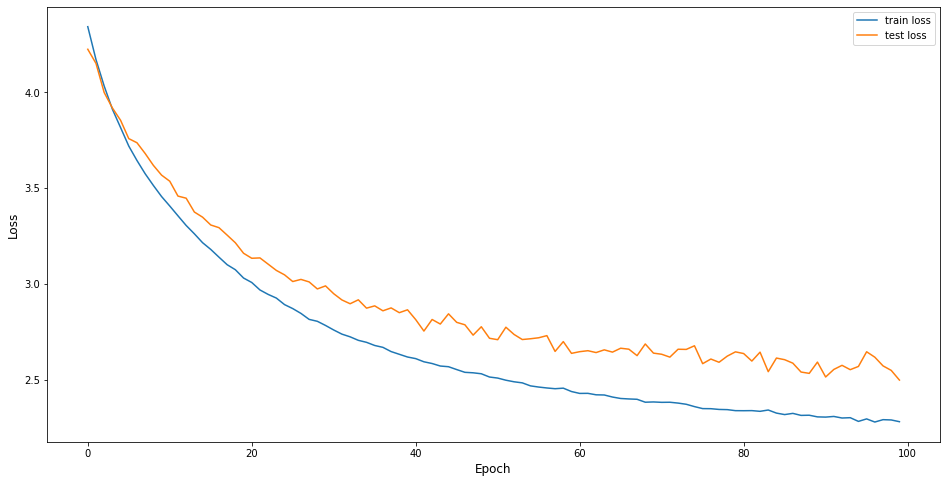

In [25]:
train(model, train_batches, test_batches, optim)

In [26]:
model.train(False)
y_pred, y_true = [], []
for X_batch, y_batch in iter(test_batches):
    logits = model(X_batch)
    y_pred += logits.argmax(dim=-1).cpu().tolist()
    y_true += y_batch.cpu().tolist()
print(f1_score(y_true, y_pred, average='micro'))

0.4004798560431871


Нечего сказать, просто ВО!